# Truck 2: GPS Speed vs. Wheel-Based Speed

#### Imports and global variables are defined here.

In [1]:
# Imports required for this notebook.
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns

# Local path to the CSV file containing the data for truck two (2).
truckTwoPath = "../data/trucks/truck2.csv"

#### Functions are defined here.

In [2]:
"""Uses Pandas's read_csv method to read a CSV file and returns a DataFrame of it to the notebook.
This function reads in all rows and defines the header row at index 0 by default."""
def readCsv(truck, records = None, headerIdx = 0):
    return pd.read_csv(truck, nrows = records, header = [headerIdx])

##### GPS Speed vs. Wheel-Based Speed

Reading in the truck data; one can change how many records are read by using "records = <#>" in the readCsv function or remove it entirely to read all records.

In [3]:
truckTwoDf = readCsv(truckTwoPath)
truckTwoDf = truckTwoDf.ffill().bfill()
#truckTwoDf.head()

Looking at basic statistics for the two columns.

In [4]:
truckTwoDf['GPS speed'].describe()

count    1.686323e+06
mean     2.268552e+01
std      1.218020e+01
min      1.136868e-13
25%      2.170956e+01
50%      2.891178e+01
75%      3.086667e+01
max      3.446778e+01
Name: GPS speed, dtype: float64

As we can see, the average GPS Speed is ~ 22.69 km/hr (~ 14.10 mph) with a standard deviation of ~ 12.18 km/hr (~ 7.57 mph). That's suspiciously low.

In [5]:
truckTwoDf['WheelBasedVehicleSpeed'].describe()

count    1.686323e+06
mean     8.213312e+01
std      4.407783e+01
min      0.000000e+00
25%      7.859375e+01
50%      1.046680e+02
75%      1.118516e+02
max      1.245898e+02
Name: WheelBasedVehicleSpeed, dtype: float64

However, for the average Wheel-Based Speed, it came out to ~ 82.13 km/hr (~ 51.04 mph) with a standard deviation of ~ 44.08 km/hr (27.39 mph).

Let's set up some graphical visualizations to get a better look at what's happening.

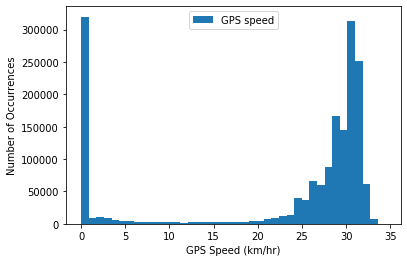

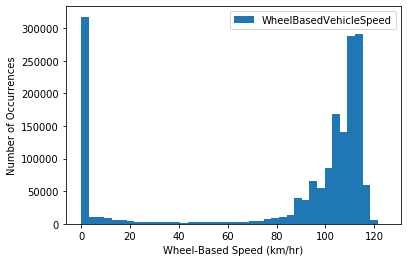

In [6]:
columns = ['GPS speed', 'WheelBasedVehicleSpeed']
gpsSpeedHist = truckTwoDf[['GPS speed']].plot.hist(stacked = True, bins = 40)
gpsSpeedHist.set_xlabel('GPS Speed (km/hr)')
gpsSpeedHist.set_ylabel('Number of Occurrences')

wheelSpeedHist = truckTwoDf[['WheelBasedVehicleSpeed']].plot.hist(stacked = True, bins = 40)
wheelSpeedHist.set_xlabel('Wheel-Based Speed (km/hr)')
wheelSpeedHist.set_ylabel('Number of Occurrences')

gpsSpeedHist
wheelSpeedHist

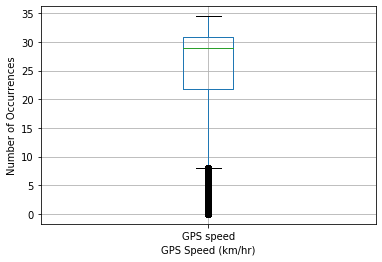

In [7]:
gpsSpeedBox = truckTwoDf[['GPS speed']].boxplot()
gpsSpeedBox.set_xlabel('GPS Speed (km/hr)')
gpsSpeedBox.set_ylabel('Number of Occurrences')

gpsSpeedBox

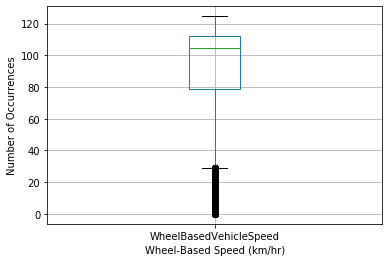

In [8]:
wheelSpeedBox = truckTwoDf[['WheelBasedVehicleSpeed']].boxplot()
wheelSpeedBox.set_xlabel('Wheel-Based Speed (km/hr)')
wheelSpeedBox.set_ylabel('Number of Occurrences')

wheelSpeedBox

It's clear that both of these components have a similar trend; there is definitely a skewness to them. However, upon further inspection, the GPS Speed has a different scale on its x-axis. These are both supposed to be measured in km/hr.

It's possible that:
- The provided units for GPS Speed were incorrect.
- The GPS Speed unit is configured to a different unit of measurement (accidental or intentional).
  - Note: we have not yet found a conversion that matches the readings.
- The GPS Speed unit was incorrectly set up.

We can also see that there is a significant amount of readings near zero. We hypothesize that these values are from moments of inactivity, such as stopping at a light or leaving the truck on without moving. Outlier detection is currently being developed and will hopefully snuff these values out.

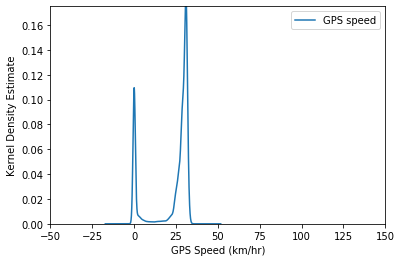

In [14]:
gpsSpeedDist = truckTwoDf[['GPS speed']].plot.kde()
gpsSpeedDist.set_xlabel('GPS Speed (km/hr)')
gpsSpeedDist.set_ylabel('Kernel Density Estimate')
gpsSpeedDist.set_xlim(-50, 150)
gpsSpeedDist.set_ylim(0.00, 0.175)

gpsSpeedDist

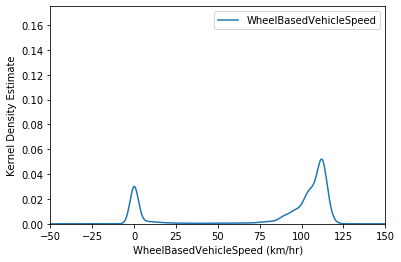

In [15]:
wheelSpeedDist = truckTwoDf[['WheelBasedVehicleSpeed']].plot.kde()
wheelSpeedDist.set_xlabel('WheelBasedVehicleSpeed (km/hr)')
wheelSpeedDist.set_ylabel('Kernel Density Estimate')
wheelSpeedDist.set_xlim(-50, 150)
wheelSpeedDist.set_ylim(0.00, 0.175)

wheelSpeedDist

At this point, since we haven't removed outliers or the movements of zero (stopped), there are two peaks which means that the raw data is bimodal. This would typically indicate that there are two groups within the data set; this data could technically have two groups: a stopped state and a moving state, where stopped represents all of the points near zero and the moving state represents all of the points near the right peak.

Let's take a look at the difference between GPS Speed and Wheel-Based Vehicle Speed and its basic statistics.

In [16]:
gpsVsWheelBasedChange = truckTwoDf['Difference'] = truckTwoDf['GPS speed'].sub(truckTwoDf['WheelBasedVehicleSpeed'])
gpsVsWheelBasedChange.max()
gpsVsWheelBasedChange.describe()

count    1.686323e+06
mean    -5.944761e+01
std      3.190377e+01
min     -9.496875e+01
25%     -8.093272e+01
50%     -7.577056e+01
75%     -5.689916e+01
max      2.891178e+01
dtype: float64

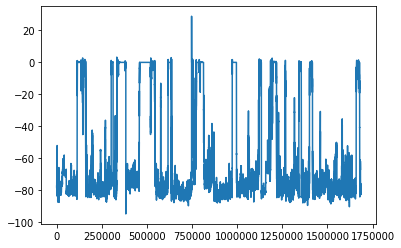

In [17]:
gpsVsWheelBasedChange.plot()

These readings are in regards from GPS Speed to Wheel-Based. I.e., if there is a negative value then it means the GPS Speed was reading lower than the Wheel-Based Speed and if there is a positive value it means the GPS Speed was reading higher than Wheel-Based Speed.

As expected, most of the readings for GPS Speed are significantly lower than those for the Wheel-Based Speed. Notably, there are quite a few instances where the difference is zero (0). Perhaps the truck was coming to a stop and the GPS couldn't update quickly enough, or maybe the unit is more messed up than originally thought.

###### Hypothesis Testing
We want to know if there is a significant difference between Truck 2's GPS Speed and Wheel-Based Vehicle Speed measurements. To do this, we will set up our two hypotheses:
- $H_{0}:$ Both mean speeds are similar.
- $H_{a}:$ Both mean speeds have a significant difference.

Due to the distributions being bimodal and the difference plot barely being a distribution, we can use the Central Limit Theorem (code based on Dr. Mohanty's code in Lecture 06, Slide Set 4) in order to have some normal data to work with. It is calculating the mean of the means of multiple samples from the data to calculate these curves.

Since there are two samples, we can perform a two-sample t-test with resulting normal distributions from the CLT. 

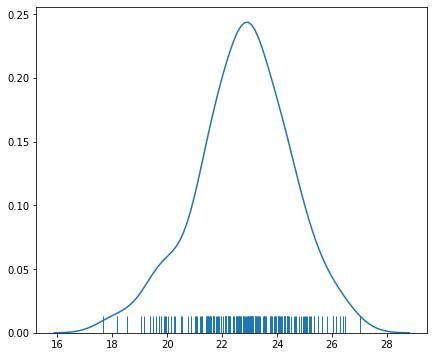

In [18]:
# Create empty list for point estimates.
pointEstimatesGPS = []

# Runs through GPS Speed to get 200 samples, each of size 50.
for x in range(200):
    sample = np.random.choice(a = truckTwoDf['GPS speed'], size=50)
    pointEstimatesGPS.append(sample.mean())
    
# Set up distribution graph size.
f, ax = plt.subplots(figsize=(7, 6))

# Plot post-CLT distribution of GPS Speed.
meansOfGPS = sns.distplot(pointEstimatesGPS, hist=False, rug=True);
meansOfGPS

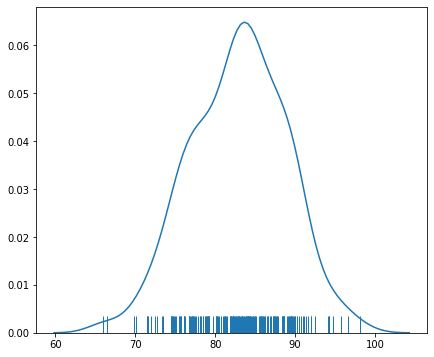

In [19]:
# Create empty list for point estimates.
pointEstimatesWheel = []

# Runs through Wheel-Based Vehicle Speed to get 200 samples, each of size 50.
for x in range(200):
    sample = np.random.choice(a = truckTwoDf['WheelBasedVehicleSpeed'], size=50)
    pointEstimatesWheel.append(sample.mean())
    
# Set up distribution graph size.
f, ax = plt.subplots(figsize=(7, 6))

# Plot post-CLT distribution of Wheel-Based Vehicle Speed.
meansOfWheel = sns.distplot(pointEstimatesWheel, hist=False, rug=True); # Plot sample mean density
meansOfWheel

With these two approximately normal distributions, we can perform our two-sample t-test. This will be performed at a confidence level of 95% with an alpha value of 0.05. We will not be assuming equal variance.

In [20]:
stats.ttest_ind(a = pointEstimatesGPS, b = pointEstimatesWheel, equal_var = False)

Ttest_indResult(statistic=-137.77770258328155, pvalue=1.4861947570175362e-224)

As we can see, the p-value is _much_ lower than the 0.05 alpha level (it's practically zero, which indicates a near-impossibility; no surprise there). Thus, we reject the null hypothesis and can conclude that there is definitely a significant difference between the two means of speeds.

This concludes the initial analysis of GPS Speed and WheelBasedVehicleSpeed for Truck 2.